In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

ADD data preprocessing
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
          type  distance  pathloss  heightTM  frequency  heightTB  heightB  heightM
type 2713    m      1.00     97.57      0.01       2249        30       15        2
     2714    m      1.00    137.38      0.03       2249        30       15        2
     2715    m      1.00     99.98      0.01       2249        30       15        2
     2716    m      1.00    128.57      0.04       2249        30       15        2
     2717    m      1.00    119.13      0.03       2249        30       15        2
Combined data set: (31188, 8)
type filterin

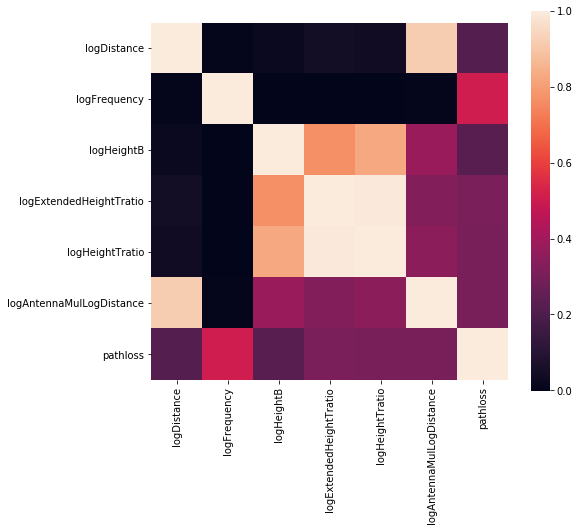

In [2]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

targetCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance']
yCols = 'pathloss'

print("\nADD data description")
print(addData.describe()['pathloss'])
# print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data[pathloss]")
print(addData.cov()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)


In [3]:
%autoreload
samplingRatio = 0.7
addDataSample = samplingData(addData[targetCols], samplingRatio)
# addDataSample.sort_values(by=['logDistance'])

normalizer = 'standard'

X, scaler = normalizeData(addDataSample[xCols], scaler = normalizer)
Y = np.array(addDataSample[yCols])

data distribution(before)
       logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance  pathloss
count     79125.00      79125.00    79125.00    79125.00                 79125.00         79125.00                  79125.00  79125.00
mean          0.31          3.03        1.05        0.30                    -0.40            -0.32                      0.32    127.47
std           0.12          0.32        0.16        0.00                     0.26             0.33                      0.14     16.61
min           0.00          2.60        0.85        0.30                    -0.95            -1.00                      0.00     85.06
25%           0.23          2.60        0.85        0.30                    -0.62            -0.62                      0.24    114.91
50%           0.33          3.15        1.18        0.30                    -0.39            -0.27                      0.33    127.17
75%           0.40          3

In [4]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

modelList = []
dataSet = []
i = 1
trainErrSum, testErrSum = 0, 0
for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = ann_mlp_regression(X_train, y_train.flatten(), (60,), activation='logistic', optimizer='lbfgs')

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    trainErrSum += trainError
    testErrSum += testError
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    modelList.append(model)
    filename = 'model/ann_model_' + str(i) + '.sav'
    pickle.dump(model, open(filename, 'wb'))
    i+=1
i-=1
avgTrainError, avgTestError = trainErrSum/i, testErrSum/i 
print("\nAverage train error:{:.2f} | Average test error:{:.2f}".format(avgTrainError, avgTestError))

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:10.449135206961955 / test:10.536411230746502
#2 Error(RMSE)-train:10.37434347281812 / test:10.74288495349094
#3 Error(RMSE)-train:10.464446642571055 / test:10.572365730251844
#4 Error(RMSE)-train:10.322415002085709 / test:10.41985089822815
#5 Error(RMSE)-train:10.321958933728839 / test:10.521977675530042

Average train error:10.39 | Average test error:10.56


Group-  3.35Ghz Data shape:(14583, 8)
Group-  2.60Ghz Data shape:(14742, 8)
Group-  3.15Ghz Data shape:(14985, 8)


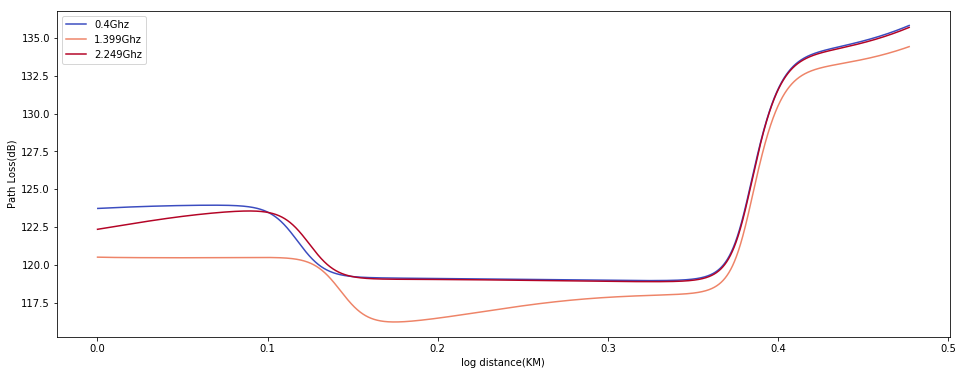

Group-  3.35Ghz Data shape:(14529, 8)
Group-  2.60Ghz Data shape:(14831, 8)
Group-  3.15Ghz Data shape:(14950, 8)


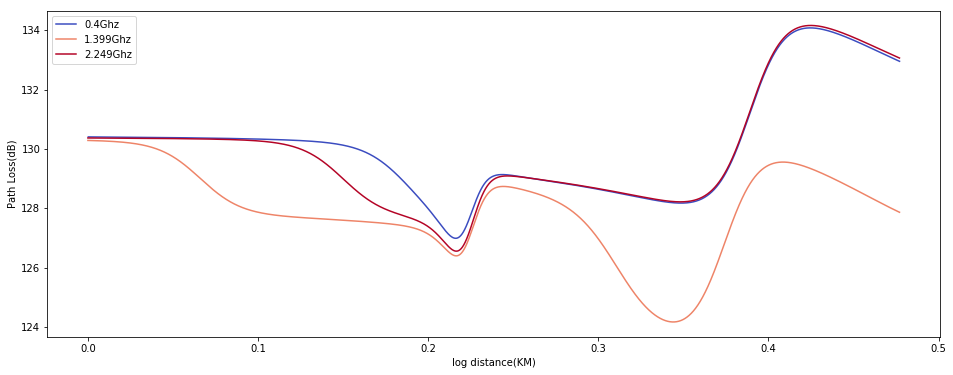

Group-  3.35Ghz Data shape:(14549, 8)
Group-  2.60Ghz Data shape:(14795, 8)
Group-  3.15Ghz Data shape:(14966, 8)


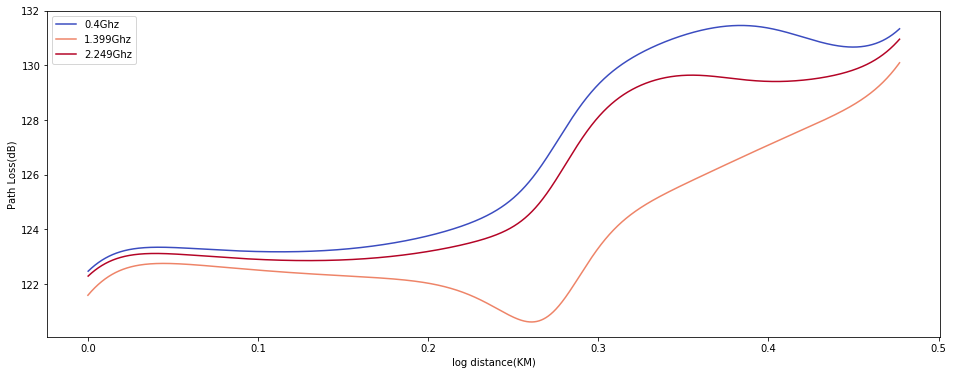

Group-  3.35Ghz Data shape:(14603, 8)
Group-  2.60Ghz Data shape:(14730, 8)
Group-  3.15Ghz Data shape:(14978, 8)


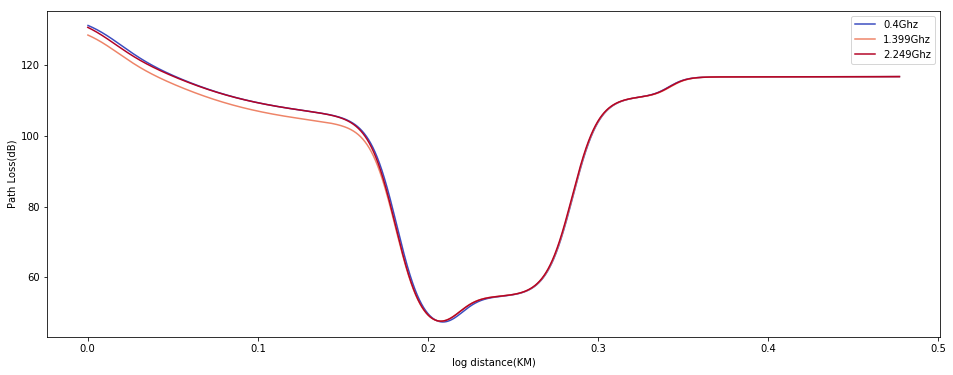

Group-  3.35Ghz Data shape:(14620, 8)
Group-  2.60Ghz Data shape:(14842, 8)
Group-  3.15Ghz Data shape:(14849, 8)


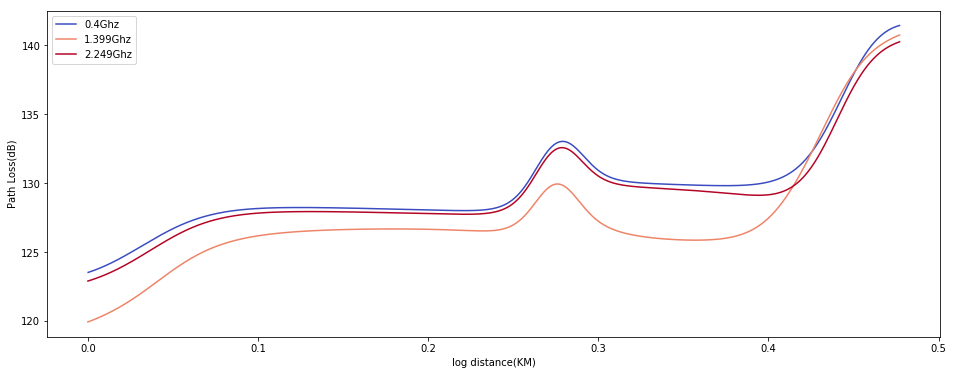

In [5]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    X_train = scaler.inverse_transform(X_train)
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio'])

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_2d_graph(model, graphX, graphY, ['logDistance', 'logAntennaMulLogDistance'])
    i+=1

3D graph for log distance and log frequency - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00         -0.17        0.01        0.00                     0.00             0.00                     -0.33
std           0.00          0.69        0.00        0.00                     0.00             0.00                      1.21
min          -0.00         -1.36        0.01        0.00                     0.00             0.00                     -2.40
25%          -0.00         -0.77        0.01        0.00                     0.00             0.00                     -1.36
5

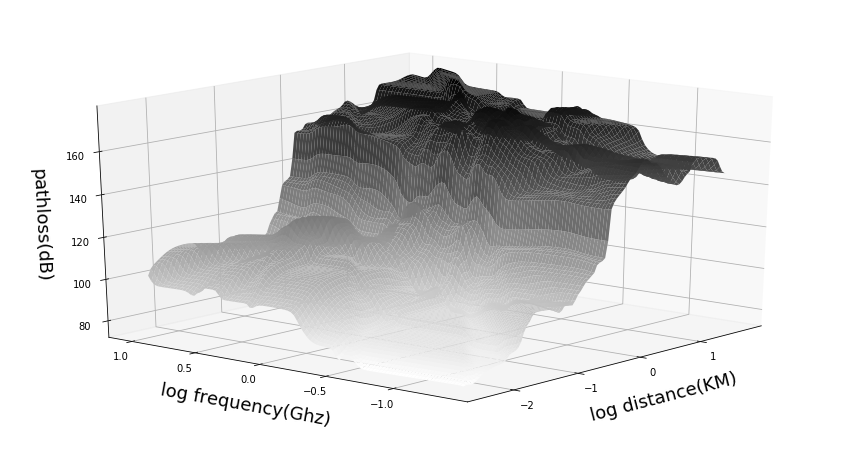

3D graph for log distance and log frequency - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00         -0.17       -0.00        0.00                     0.00             0.00                     -0.33
std           0.00          0.69        0.00        0.00                     0.00             0.00                      1.21
min          -0.00         -1.36       -0.00        0.00                     0.00             0.00                     -2.40
25%          -0.00         -0.77       -0.00        0.00                     0.00             0.00                     -1.36
5

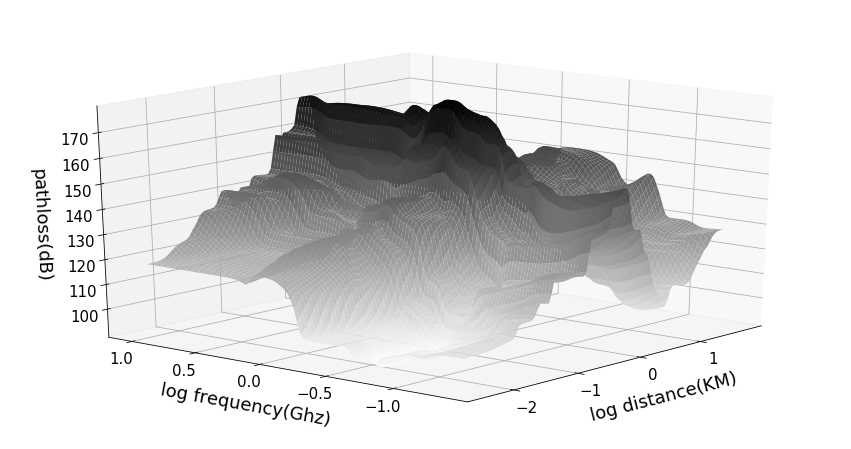

3D graph for log distance and log frequency - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00         -0.17        0.00        0.00                    -0.00            -0.00                     -0.33
std           0.00          0.69        0.00        0.00                     0.00             0.00                      1.21
min          -0.00         -1.36        0.00        0.00                    -0.00            -0.00                     -2.40
25%          -0.00         -0.77        0.00        0.00                    -0.00            -0.00                     -1.36
5

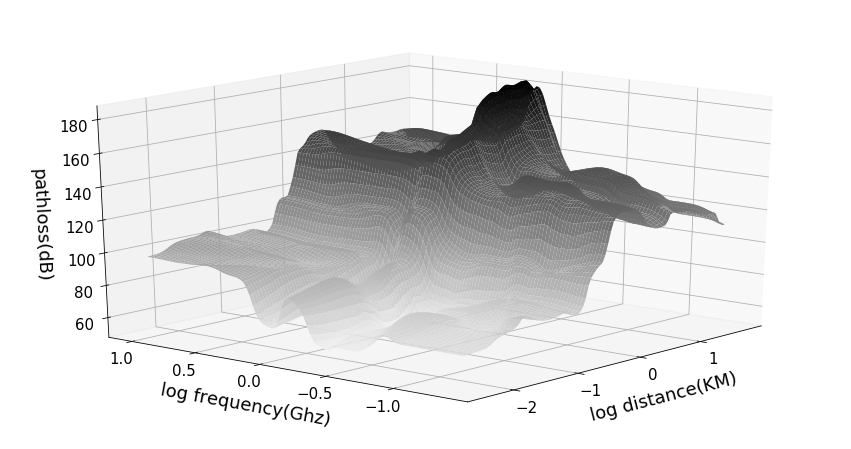

3D graph for log distance and log frequency - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.00         -0.17       -0.00        0.00                    -0.00            -0.00                     -0.33
std           0.00          0.69        0.00        0.00                     0.00             0.00                      1.21
min           0.00         -1.36       -0.00        0.00                    -0.00            -0.00                     -2.40
25%           0.00         -0.77       -0.00        0.00                    -0.00            -0.00                     -1.36
5

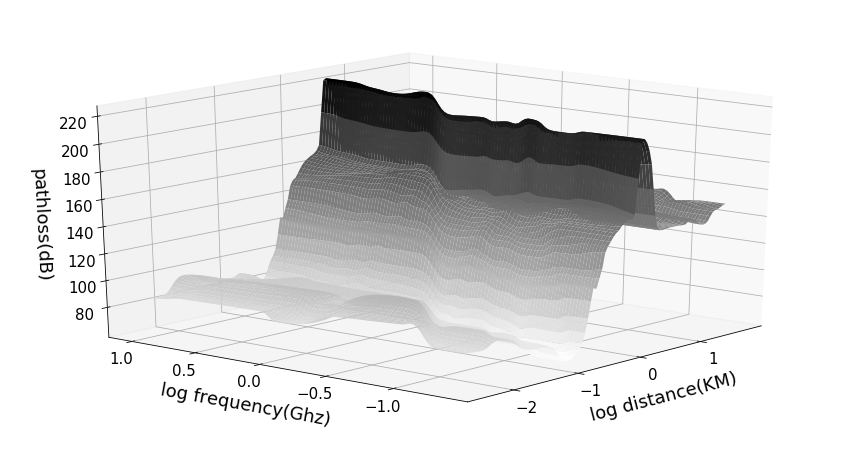

3D graph for log distance and log frequency - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.00         -0.17       -0.00        0.00                    -0.00            -0.00                     -0.33
std           0.00          0.69        0.00        0.00                     0.00             0.00                      1.21
min           0.00         -1.36       -0.00        0.00                    -0.00            -0.00                     -2.40
25%           0.00         -0.77       -0.00        0.00                    -0.00            -0.00                     -1.36
5

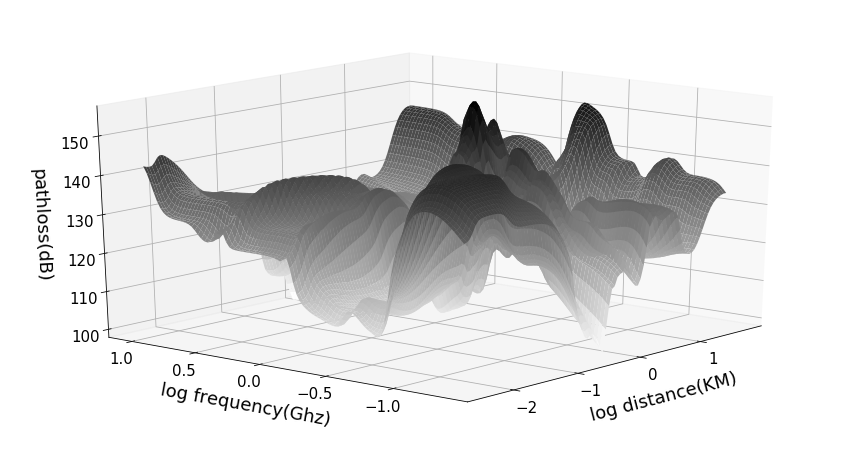

In [6]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log frequency - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logFrequency']
    xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00          0.00        0.01        0.00                     0.39             0.00                     -0.33
std           0.00          0.00        0.00        0.00                     1.46             0.00                      1.21
min          -0.00          0.00        0.01        0.00                    -2.12             0.00                     -2.40
25%          -0.00          0.00        0.01        0.00                    -0.86             0.00       

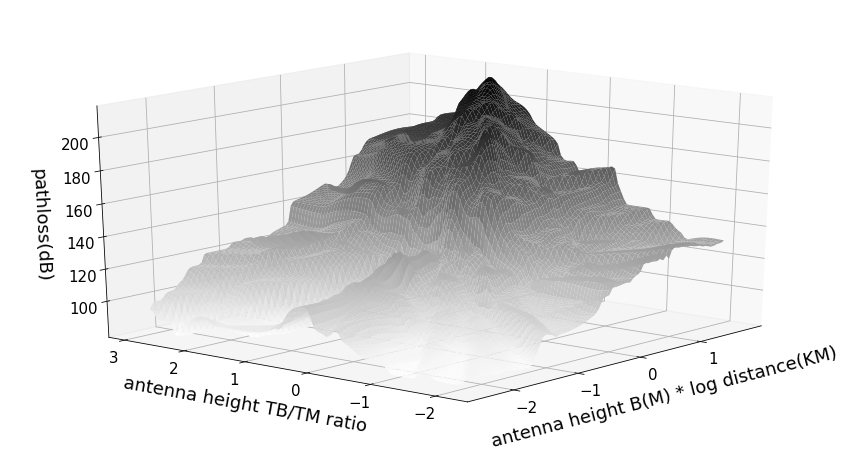

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00         -0.00       -0.00        0.00                     0.39             0.00                     -0.33
std           0.00          0.00        0.00        0.00                     1.46             0.00                      1.21
min          -0.00         -0.00       -0.00        0.00                    -2.12             0.00                     -2.40
25%          -0.00         -0.00       -0.00        0.00                    -0.86             0.00       

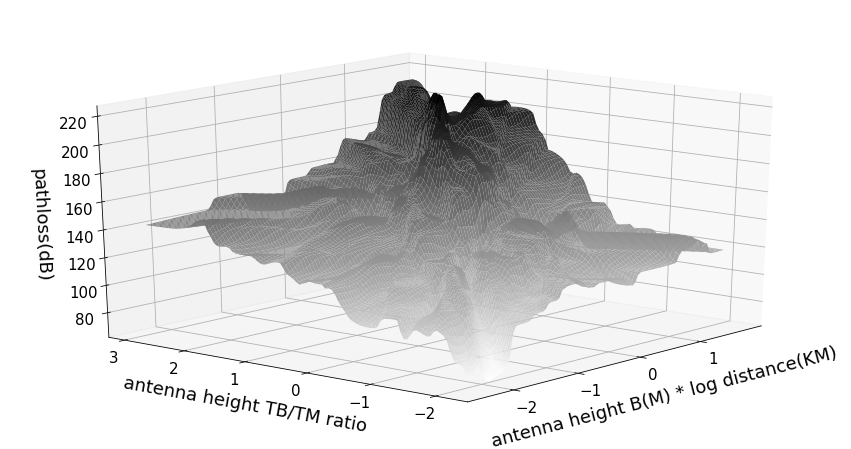

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00         -0.00        0.00        0.00                     0.39            -0.00                     -0.33
std           0.00          0.00        0.00        0.00                     1.46             0.00                      1.21
min          -0.00         -0.00        0.00        0.00                    -2.12            -0.00                     -2.40
25%          -0.00         -0.00        0.00        0.00                    -0.86            -0.00       

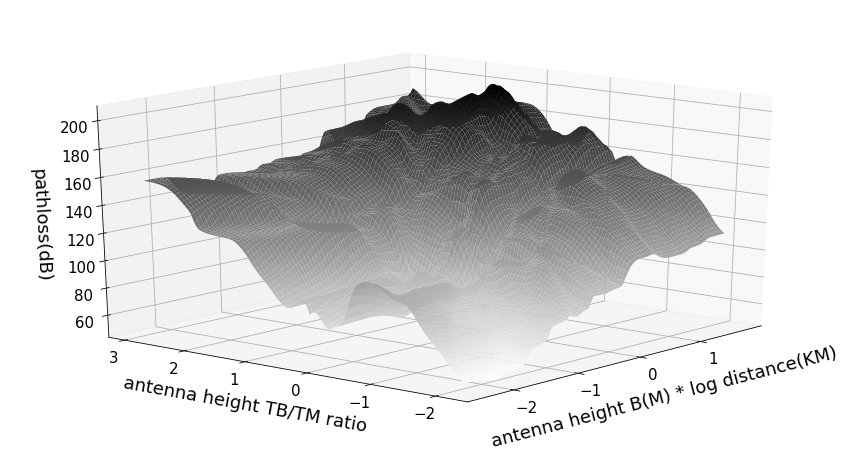

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.00          0.00       -0.00        0.00                     0.39            -0.00                     -0.33
std           0.00          0.00        0.00        0.00                     1.46             0.00                      1.21
min           0.00          0.00       -0.00        0.00                    -2.12            -0.00                     -2.40
25%           0.00          0.00       -0.00        0.00                    -0.86            -0.00       

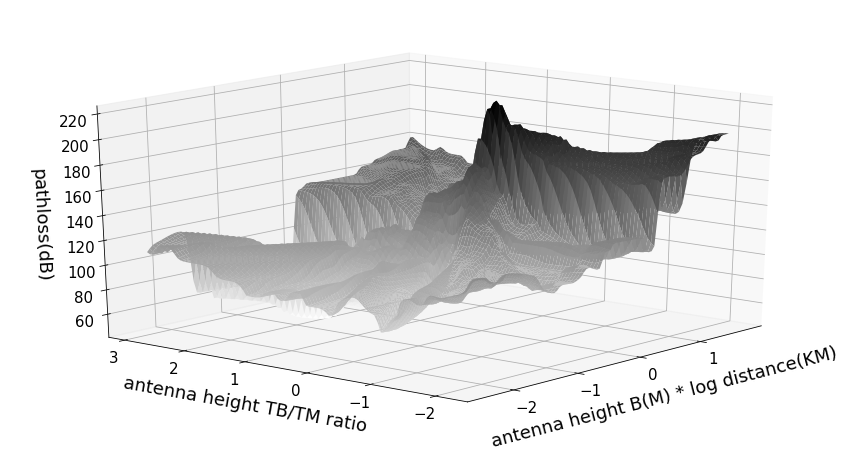

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.00         -0.00       -0.00        0.00                     0.39            -0.00                     -0.33
std           0.00          0.00        0.00        0.00                     1.46             0.00                      1.21
min           0.00         -0.00       -0.00        0.00                    -2.12            -0.00                     -2.40
25%           0.00         -0.00       -0.00        0.00                    -0.86            -0.00       

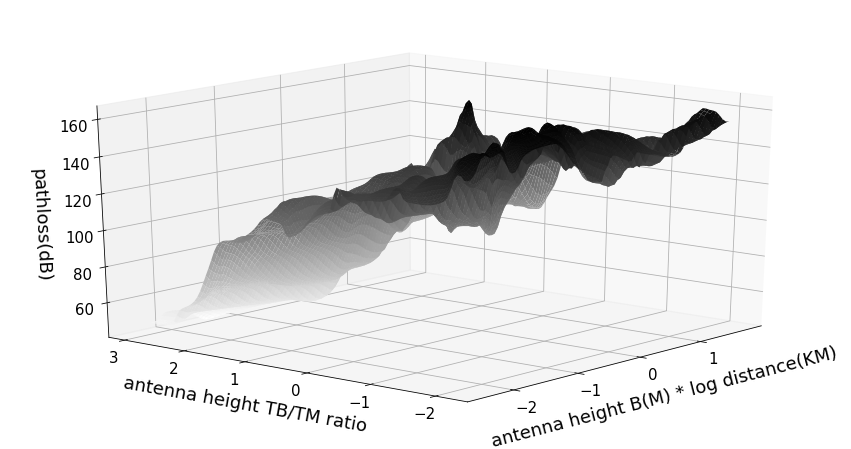

In [7]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height TB/TM ratio","pathloss(dB)"
    varX = ['logAntennaMulLogDistance', 'logExtendedHeightTratio']
    data = makeXforGraph(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), varX)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height B ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00          0.00       -0.26        0.00                     0.00             0.00                     -0.33
std           0.00          0.00        0.60        0.00                     0.00             0.00                      1.21
min          -0.00          0.00       -1.30        0.00                     0.00             0.00                     -2.40
25%          -0.00          0.00       -0.78        0.00                     0.00             0.00               

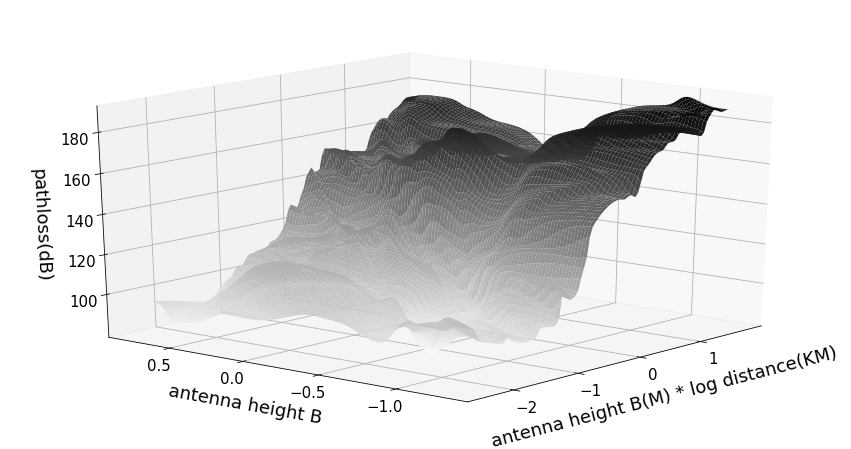

3D graph for log distance and log antenna height B ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00         -0.00       -0.26        0.00                     0.00             0.00                     -0.33
std           0.00          0.00        0.60        0.00                     0.00             0.00                      1.21
min          -0.00         -0.00       -1.30        0.00                     0.00             0.00                     -2.40
25%          -0.00         -0.00       -0.78        0.00                     0.00             0.00               

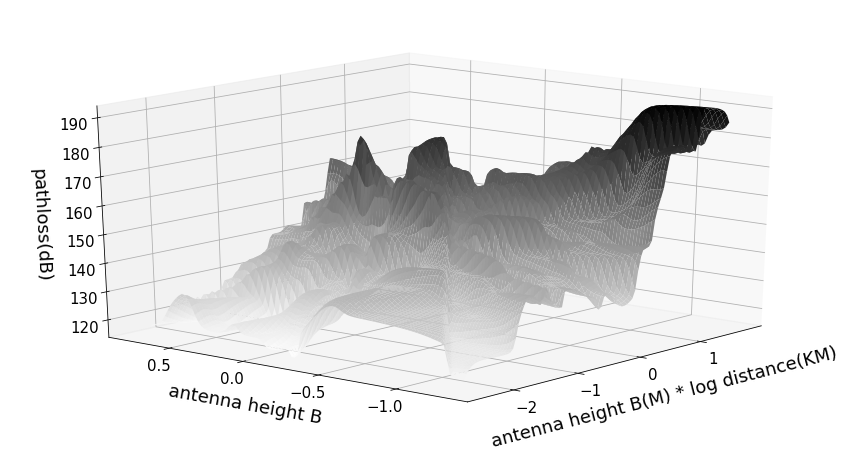

3D graph for log distance and log antenna height B ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.00         -0.00       -0.26        0.00                    -0.00            -0.00                     -0.33
std           0.00          0.00        0.60        0.00                     0.00             0.00                      1.21
min          -0.00         -0.00       -1.30        0.00                    -0.00            -0.00                     -2.40
25%          -0.00         -0.00       -0.78        0.00                    -0.00            -0.00               

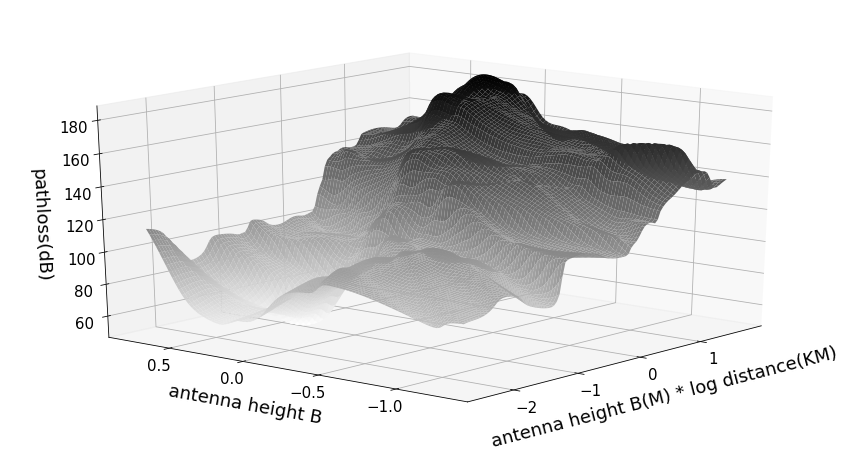

3D graph for log distance and log antenna height B ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.00          0.00       -0.26        0.00                    -0.00            -0.00                     -0.33
std           0.00          0.00        0.60        0.00                     0.00             0.00                      1.21
min           0.00          0.00       -1.30        0.00                    -0.00            -0.00                     -2.40
25%           0.00          0.00       -0.78        0.00                    -0.00            -0.00               

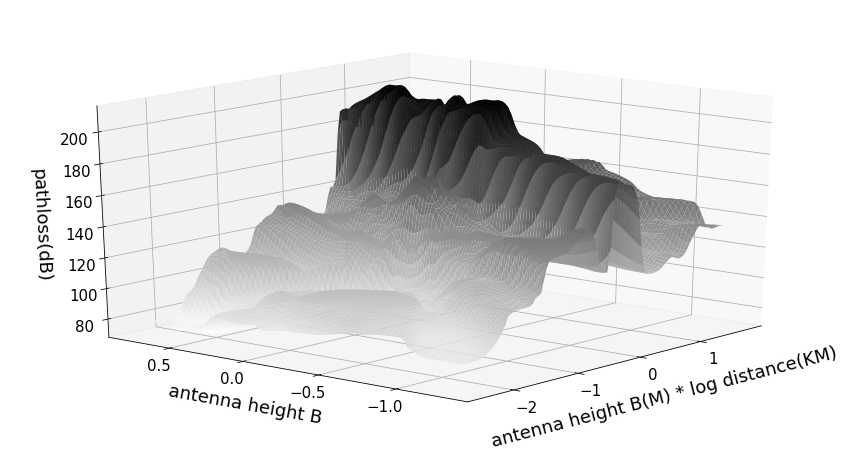

3D graph for log distance and log antenna height B ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.00         -0.00       -0.26        0.00                    -0.00            -0.00                     -0.33
std           0.00          0.00        0.60        0.00                     0.00             0.00                      1.21
min           0.00         -0.00       -1.30        0.00                    -0.00            -0.00                     -2.40
25%           0.00         -0.00       -0.78        0.00                    -0.00            -0.00               

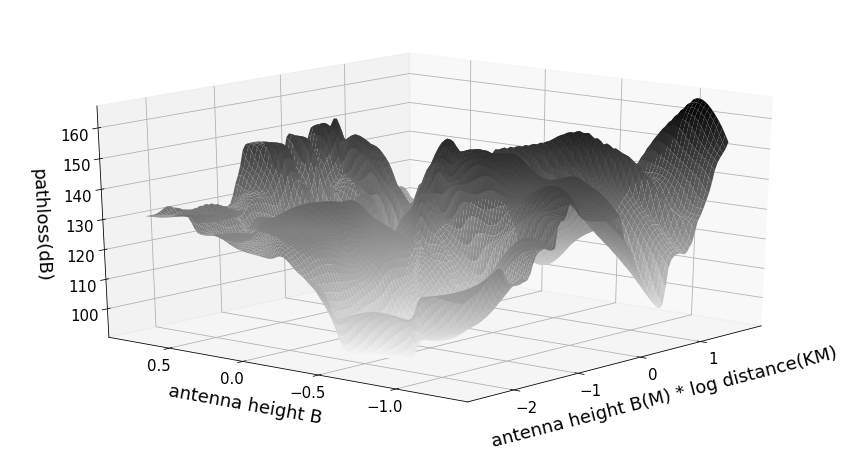

In [8]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
    varX = ['logAntennaMulLogDistance', 'logHeightB']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height B","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), varX)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)
    i+=1

Equation Derivation for trainset #1
Group-  3.35Ghz Data shape:(14583, 8)
Group-  2.60Ghz Data shape:(14742, 8)
Group-  3.15Ghz Data shape:(14985, 8)
ANN-Model-1-train error(RMSE): 10.449135206961955
ANN-Model-1-test error(RMSE): 10.536411230746502
MultiLinear-1-train error(RMSE): 20.197668636106073
MultiLinear-1-test error(RMSE): 20.26934390742945

Objective Function with manual normalization data
L_pathloss = (152.65 + -126.14log_hb)log_d +   0.43log_f +   0.00log_hb +  -0.00log_hm + -58.63log_(h_tb + h_b/h_tm + h_m) +  40.74log_(h_tb/h_tm) + 106.35
RMSE(ANN-MultiLinear): 4.137830582903477


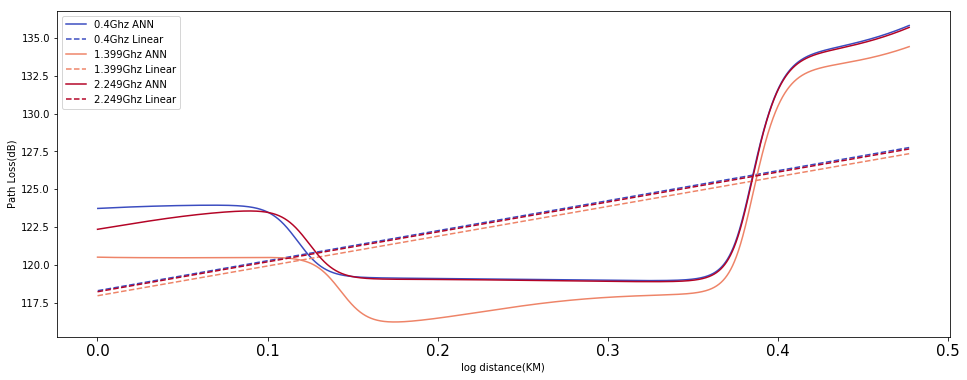

Equation Derivation for trainset #2
Group-  3.35Ghz Data shape:(14529, 8)
Group-  2.60Ghz Data shape:(14831, 8)
Group-  3.15Ghz Data shape:(14950, 8)
ANN-Model-2-train error(RMSE): 10.37434347281812
ANN-Model-2-test error(RMSE): 10.74288495349094
MultiLinear-2-train error(RMSE): 18.41392836384345
MultiLinear-2-test error(RMSE): 18.609663077026863

Objective Function with manual normalization data
L_pathloss = ( 88.65 + -81.96log_hb)log_d +   3.43log_f + 129.95log_hb +  -0.00log_hm + 498.75log_(h_tb + h_b/h_tm + h_m) + -448.14log_(h_tb/h_tm) +  33.47
RMSE(ANN-MultiLinear): 3.9826890759590916


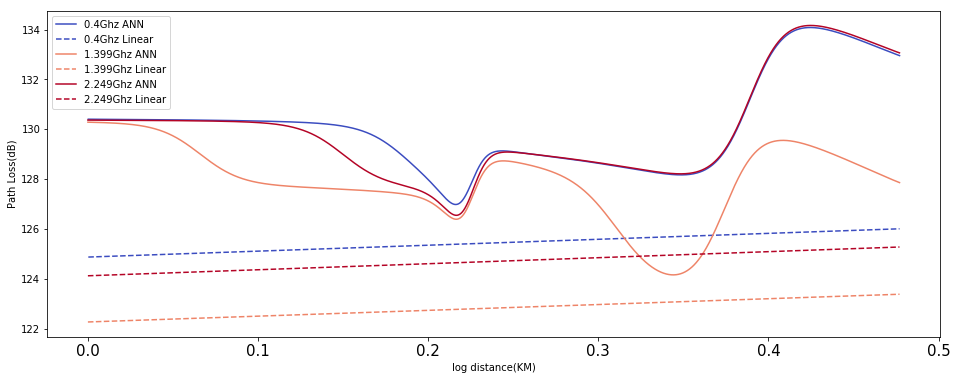

Equation Derivation for trainset #3
Group-  3.35Ghz Data shape:(14549, 8)
Group-  2.60Ghz Data shape:(14795, 8)
Group-  3.15Ghz Data shape:(14966, 8)
ANN-Model-3-train error(RMSE): 10.464446642571055
ANN-Model-3-test error(RMSE): 10.572365730251844
MultiLinear-3-train error(RMSE): 18.995831233900592
MultiLinear-3-test error(RMSE): 18.893533263842997

Objective Function with manual normalization data
L_pathloss = ( 57.93 + -34.95log_hb)log_d +   3.31log_f +  22.73log_hb +  -0.00log_hm +  19.99log_(h_tb + h_b/h_tm + h_m) +  23.72log_(h_tb/h_tm) +  96.01
RMSE(ANN-MultiLinear): 3.976220008143431


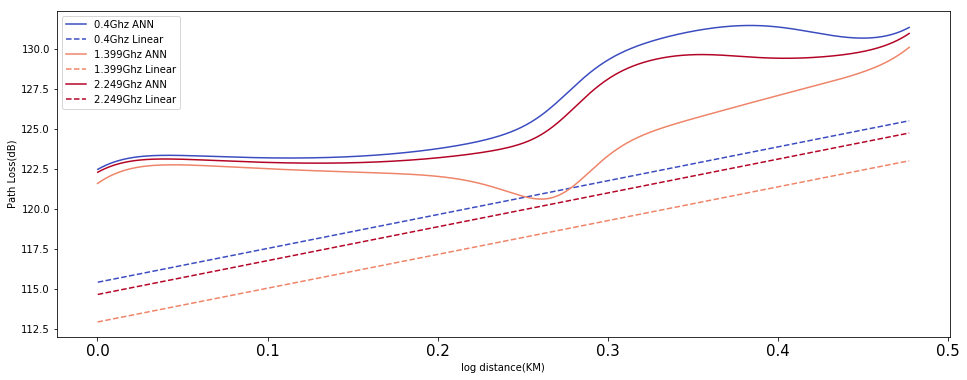

Equation Derivation for trainset #4
Group-  3.35Ghz Data shape:(14603, 8)
Group-  2.60Ghz Data shape:(14730, 8)
Group-  3.15Ghz Data shape:(14978, 8)
ANN-Model-4-train error(RMSE): 10.322415002085709
ANN-Model-4-test error(RMSE): 10.41985089822815
MultiLinear-4-train error(RMSE): 31.81902326728808
MultiLinear-4-test error(RMSE): 31.65224604939192

Objective Function with manual normalization data
L_pathloss = (275.29 + -194.85log_hb)log_d +   0.03log_f + 208.77log_hb +   0.00log_hm + 472.35log_(h_tb + h_b/h_tm + h_m) + -454.07log_(h_tb/h_tm) + -93.66
RMSE(ANN-MultiLinear): 22.578031969770784


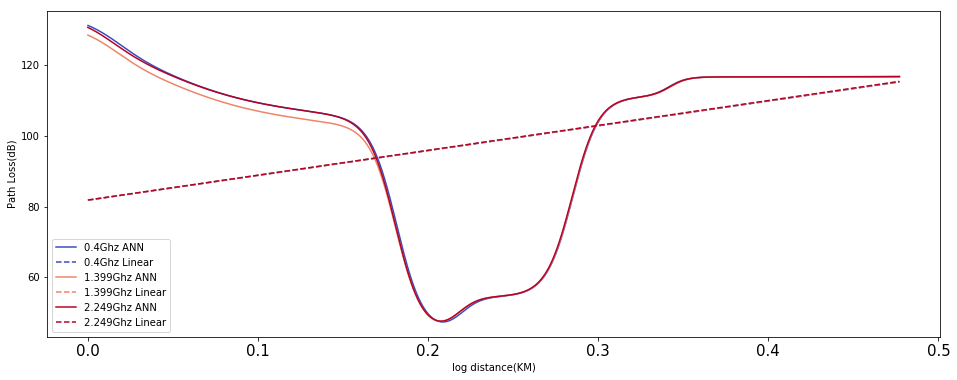

Equation Derivation for trainset #5
Group-  3.35Ghz Data shape:(14620, 8)
Group-  2.60Ghz Data shape:(14842, 8)
Group-  3.15Ghz Data shape:(14849, 8)
ANN-Model-5-train error(RMSE): 10.321958933728839
ANN-Model-5-test error(RMSE): 10.521977675530042
MultiLinear-5-train error(RMSE): 18.931777136534947
MultiLinear-5-test error(RMSE): 18.923138886875012

Objective Function with manual normalization data
L_pathloss = (201.62 + -165.08log_hb)log_d +   0.69log_f +  75.04log_hb +  -0.00log_hm + 197.44log_(h_tb + h_b/h_tm + h_m) + -180.21log_(h_tb/h_tm) +  59.88
RMSE(ANN-MultiLinear): 3.8337682162493447


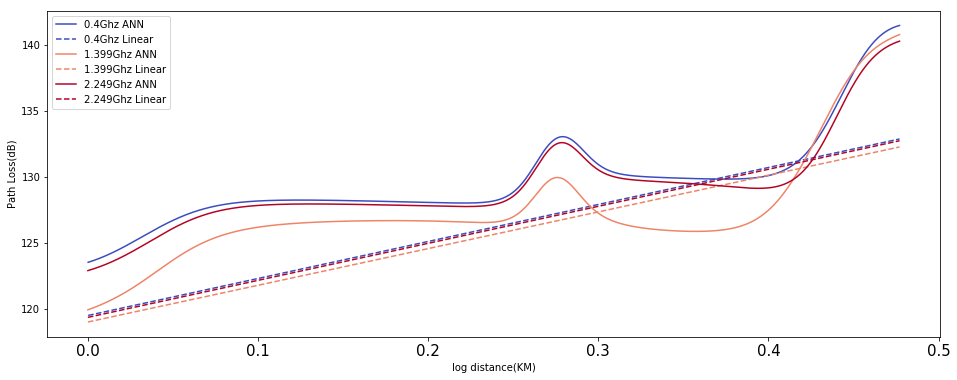


AVG Objective Function
L_pathloss = (155.23 + -120.60log_hb)log_d +   1.58log_f +  87.30log_hb +  -0.00log_hm + 225.98log_(h_tb + h_b/h_tm + h_m) + -203.59log_(h_tb/h_tm) +  40.41
object function error(RMSE): 112.92646202281276


In [10]:
%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
i = 1
coefSum, interceptSum = np.array([0]*7), 0
for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    X_train = scaler.inverse_transform(X_train)
    X_test = scaler.inverse_transform(X_test)
    print("="*120)
    print("Equation Derivation for trainset #{}".format(i))
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio'])

    ANNmodel = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))
    ANNPred = ANNmodel.predict(X_train)
    
    linearModel = Ridge(alpha=0.001).fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    print("ANN-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("ANN-Model-"+str(i)+"-test error(RMSE):", testError)  
    print("MultiLinear-"+str(i)+"-train error(RMSE):",RMSE_LIN_TRAIN)
    print("MultiLinear-"+str(i)+"-test error(RMSE):",RMSE_LIN_TEST)
    
    print("\nObjective Function with manual normalization data")
    print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb + h_b/h_tm + h_m) + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
          .format(linearModel.coef_[0],linearModel.coef_[6],linearModel.coef_[1],\
                  linearModel.coef_[2],linearModel.coef_[3],linearModel.coef_[4], linearModel.coef_[5], linearModel.intercept_))    
    coefSum = np.add(linearModel.coef_, coefSum)
    interceptSum = np.add(linearModel.intercept_, interceptSum)
    print("RMSE(ANN-MultiLinear):", RMSE_LIN_ANN)
    graphX = data[0]
    graphY = data[1]
    ann_linear_compare_graph(ANNmodel, linearModel, graphX, graphY)

    i+=1
i-=1
avgCoef = np.divide(coefSum,i)
avgIntercept = np.divide(interceptSum,i)
#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
print("\nAVG Objective Function")
print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb + h_b/h_tm + h_m) + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
      .format(avgCoef[0],avgCoef[6],avgCoef[1],\
              avgCoef[2],avgCoef[3],avgCoef[4], avgCoef[5], avgIntercept)) 
f = lambda x: avgCoef[0]*x[:,0] + avgCoef[6]*x[:,6] + avgCoef[1] * x[:,1] + avgCoef[2]*x[:,2] + avgCoef[3]*x[:,3] + avgCoef[4]*x[:,4] + avgCoef[5]*x[:,5] + avgIntercept
pred = f(X)
error = np.sqrt(mean_squared_error(pred, Y.flatten()))
print("object function error(RMSE):",error)